## Photo Analyzer

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from rembg import remove

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

C:\Users\abdullahal.alrakin\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Using device: cuda


In [2]:
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()
        self.efficientnet = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
        self.efficientnet.classifier[1] = nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)
    
    def forward(self, x):
        return self.efficientnet(x)

In [3]:
def detect_face(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    return faces[0] if len(faces) > 0 else None

def adjust_subject_position(image):
    face = detect_face(image)
    height, width = image.shape[:2]
    
    if face is None:
        return image, False
    
    x, y, w, h = face
    face_center = (x + w//2, y + h//2)
    
    crop_height = int(h * 3.2)
    crop_width = int(crop_height * 3/4)
    
    crop_top = max(0, face_center[1] - crop_height//2)
    crop_bottom = min(height, crop_top + crop_height)
    crop_left = max(0, face_center[0] - crop_width//2)
    crop_right = min(width, crop_left + crop_width)
    
    if crop_bottom > height:
        crop_top = max(0, height - crop_height)
        crop_bottom = height
    if crop_right > width:
        crop_left = max(0, width - crop_width)
        crop_right = width
    
    cropped = image[crop_top:crop_bottom, crop_left:crop_right]
    resized = cv2.resize(cropped, (413, 531))
    
    return resized, True

def remove_background(image):
    # Convert BGR to RGB for rembg
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_image)
    output = remove(pil_image)
    output_np = np.array(output)
    
    # Create a white background
    white_background = np.ones_like(output_np[:,:,:3]) * 255
    
    # Blend the image with white background based on alpha channel
    alpha = output_np[:,:,3:] / 255.0
    result = (output_np[:,:,:3] * alpha + white_background * (1 - alpha)).astype(np.uint8)
    
    # Convert back to BGR for OpenCV
    return cv2.cvtColor(result, cv2.COLOR_RGB2BGR)

In [4]:
def process_image(image_path, model, class_names, device, transform):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image at {image_path}")
        return

    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    class_confidences = predict_with_confidence(model, rgb_image, class_names, device, transform)
    
    threshold = 0.3
    issues = [class_name for class_name, conf in class_confidences if conf > threshold and class_name != "Approved"]
    
    immediate_reject_issues = ["Hats", "Black and White", "Blurry", "Picture of a Picture", "Digitally Altered", "Too Close"]
    if any(issue in immediate_reject_issues for issue in issues):
        status = "Rejected"
        message = f"Image rejected due to: {', '.join(issues)}"
        display_result(image, None, None, class_confidences, status, message)
        return

    processed_image_1 = remove_background(image)
    processed_image_2, was_adjusted = adjust_subject_position(processed_image_1)
    
    corrections = []
    if "Background Issues" in issues:
        corrections.append("Background removed and replaced with white")
    corrections.append("Subject position adjusted")
    
    status = "Corrected"
    message = f"Image corrected for: {', '.join(corrections)}"
    
    display_result(image, processed_image_1, processed_image_2, class_confidences, status, message, corrections)
    
def predict_with_confidence(model, image, class_names, device, transform):
    model.eval()
    image_for_model = transform(image=image)['image']
    image_for_model = image_for_model.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_for_model)
        probabilities = F.softmax(outputs, dim=1)
        
    confidences = probabilities[0].cpu().numpy()
    class_confidences = [(class_names[i], conf) for i, conf in enumerate(confidences)]
    class_confidences.sort(key=lambda x: x[1], reverse=True)
    
    return class_confidences

In [5]:
def display_result(original_image, processed_image_1, processed_image_2, original_confidences, status, message, corrections=None):
    # Set up the figure
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(2, 3, figure=fig, height_ratios=[1.5, 1])

    # Display images in the top row
    image_axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
    images = [original_image, processed_image_1, processed_image_2]
    titles = ["Original Image", "Processed Image 1\n(Background Removed)", "Processed Image 2\n(Subject Adjusted)"]

    for ax, img, title in zip(image_axes, images, titles):
        if img is not None:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.axis('off')

    # Analysis Details
    ax_details = fig.add_subplot(gs[1, 0:2])
    ax_details.axis('off')
    details_text = f"""
    Status: {status}
    
    Message: {message}

    Corrections Applied:
    {chr(10).join(['• ' + c for c in corrections]) if corrections else 'None'}
    """
    ax_details.text(0.05, 0.95, details_text, va='top', ha='left', fontsize=12, 
                    fontfamily='sans-serif', transform=ax_details.transAxes,
                    bbox=dict(facecolor='#f0f0f0', edgecolor='#cccccc', alpha=0.8, boxstyle='round,pad=0.5'))

    # Confidence Scores
    ax_scores = fig.add_subplot(gs[1, 2])
    classes, scores = zip(*original_confidences)
    y_pos = range(len(classes))
    bars = ax_scores.barh(y_pos, scores, align='center', height=0.5, color='#4CAF50')
    ax_scores.set_yticks(y_pos)
    ax_scores.set_yticklabels(classes, fontsize=10)
    ax_scores.invert_yaxis()
    ax_scores.set_xlim(0, 1)
    ax_scores.set_xlabel('Confidence', fontsize=12, fontweight='bold')
    ax_scores.set_title('Confidence Scores', fontsize=14, fontweight='bold', pad=20)

    # Add value labels to the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax_scores.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
                       ha='left', va='center', fontsize=10, fontweight='bold', color='black')

    # Enhance overall aesthetics
    fig.patch.set_facecolor('#ffffff')
    for ax in fig.get_axes():
        ax.patch.set_facecolor('#f9f9f9')
        for spine in ax.spines.values():
            spine.set_visible(False)

    plt.tight_layout()
    plt.show()

In [6]:
# Load model and set up transform
model = EfficientNetModel(num_classes=9)
model_path = r'C:\Users\abdullahal.alrakin\Desktop\best_model_hats_progress.pth'
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure the model file exists and the path is correct.")
    exit(1)

transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

class_names = {
    0: "Approved",
    1: "Background Issues",
    2: "Black and White",
    3: "Blurry",
    4: "Digitally Altered",
    5: "Hats",
    6: "Picture of a Picture",
    7: "Too Close",
    8: "Too Far"
}

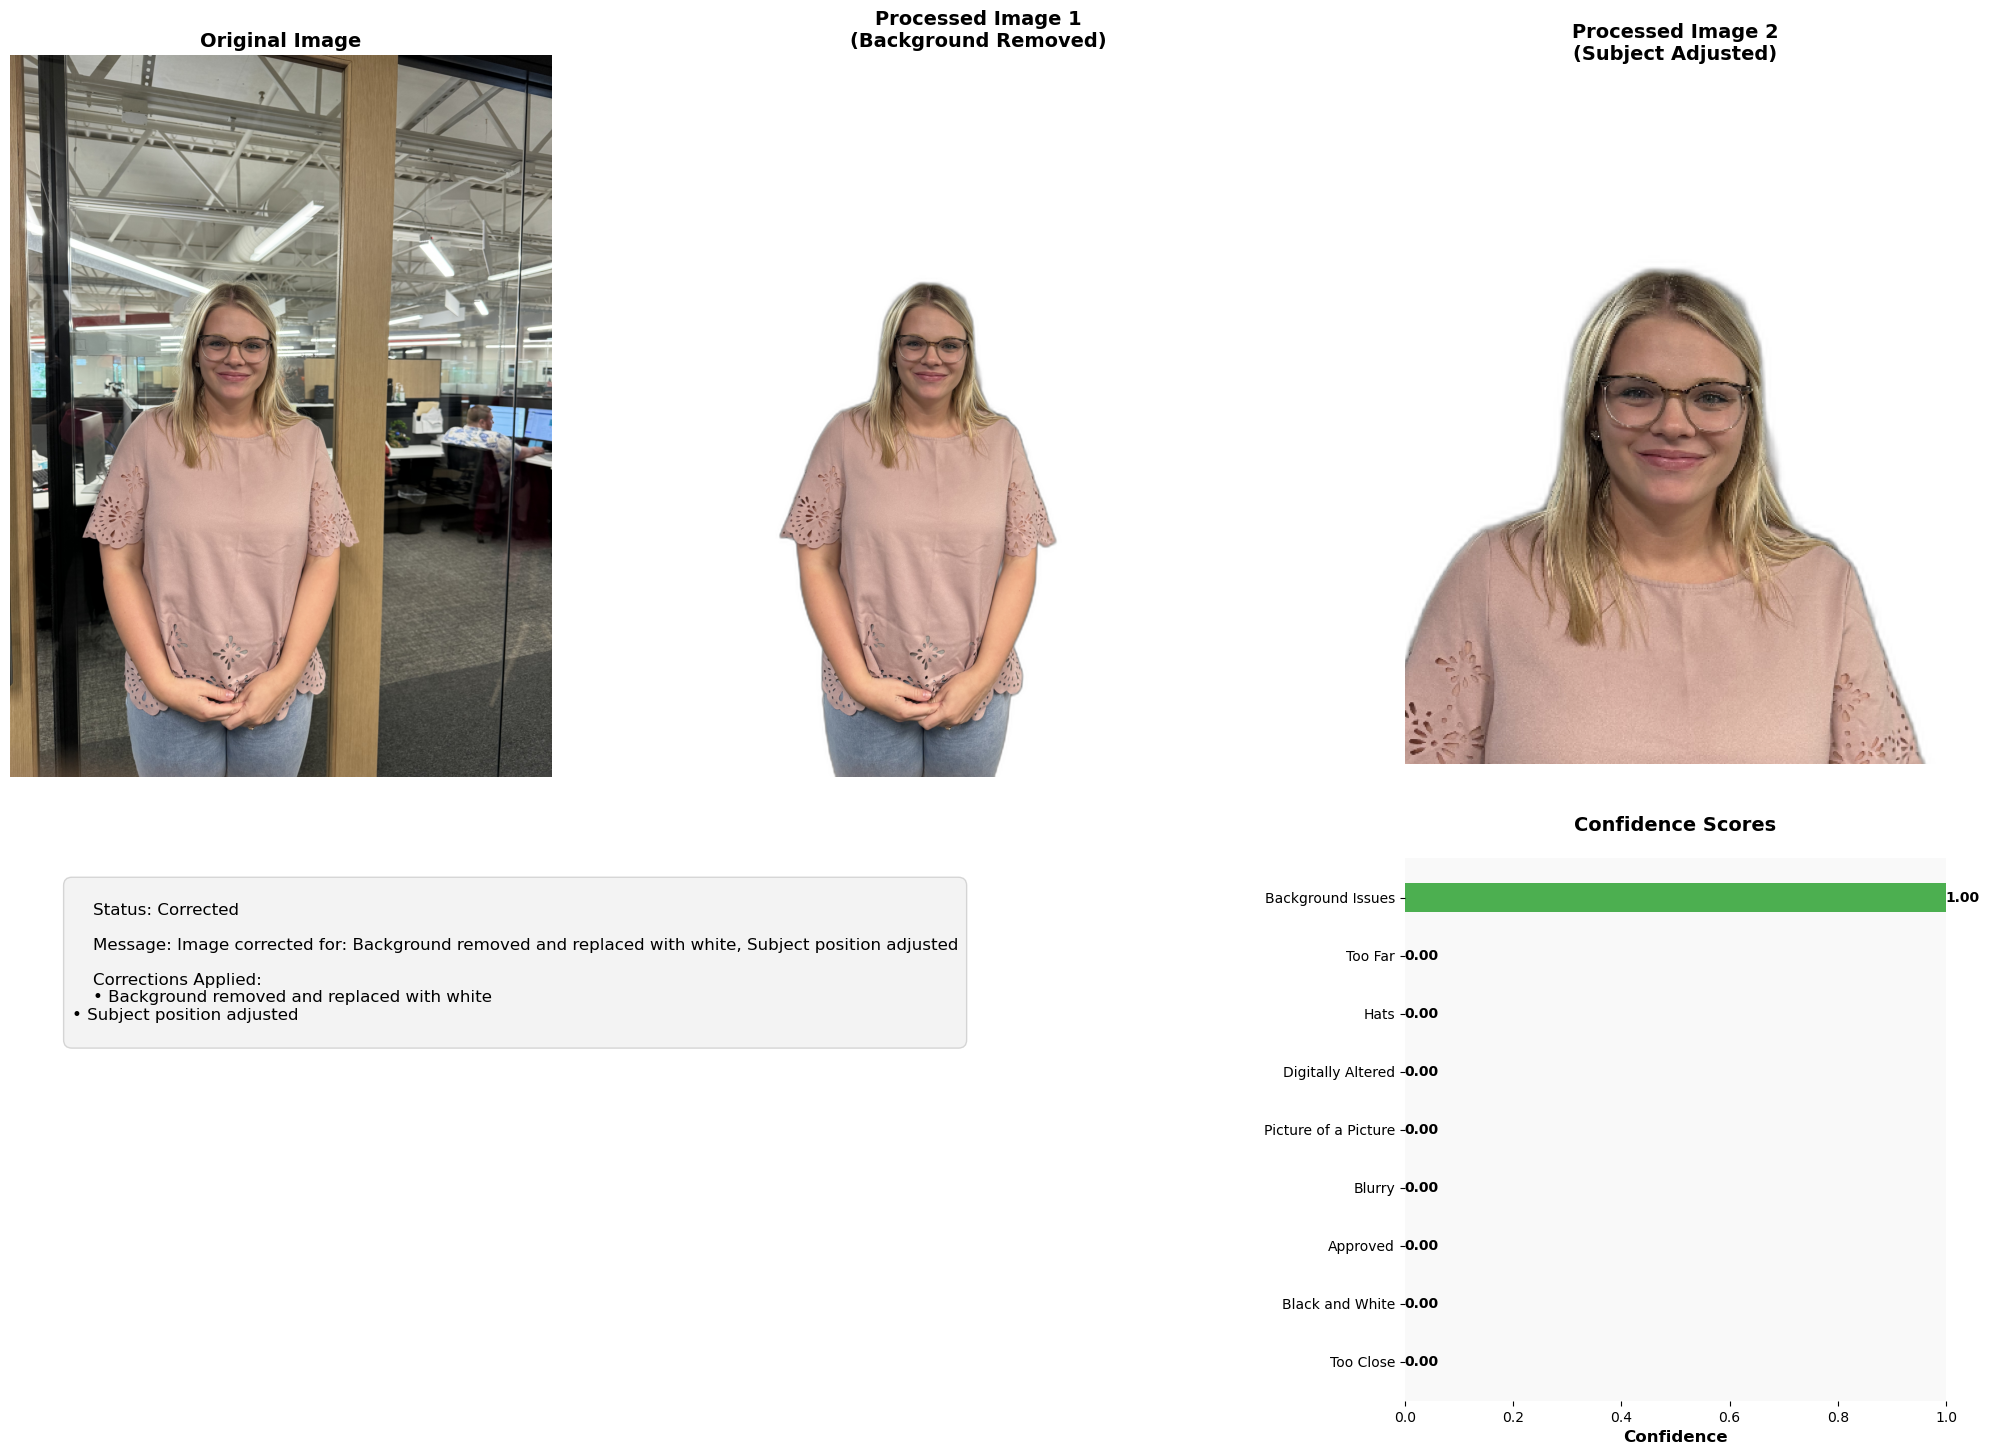

In [163]:
# Process the image
image_path = r'C:\Users\abdullahal.alrakin\Desktop\TRY TEST\IMG_0159.jpg'
process_image(image_path, model, class_names, device, transform)